In [1]:
!python --version

Python 3.13.4


In [3]:
import platform
import os
from typing import override

import torch
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

In [4]:
os.environ["COMPUTERNAME"], platform.node()

('WSLDFCB344', 'WSLDFCB344')

In [5]:
platform.system(), platform.processor()

('Windows', 'Intel64 Family 6 Model 170 Stepping 4, GenuineIntel')

In [6]:
try:
    print(os.environ["CUDA_PATH"])
except KeyError:
    print(f"CUDA is not available on {os.environ["COMPUTERNAME"]}!")

CUDA is not available on WSLDFCB344!


In [8]:
os.environ.get("PATH").split(';')

['C:\\Program Files\\PowerShell\\7',
 'C:\\Program Files\\Python313\\Scripts\\',
 'C:\\Program Files\\Python313\\',
 'C:\\WINDOWS\\system32',
 'C:\\WINDOWS',
 'C:\\WINDOWS\\System32\\Wbem',
 'C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0\\',
 'C:\\WINDOWS\\System32\\OpenSSH\\',
 'C:\\Program Files\\Microsoft VS Code\\bin',
 'C:\\Program Files\\PowerShell\\7\\',
 'C:\\Users\\90963425\\AppData\\Local\\Microsoft\\WindowsApps']

In [10]:
os.listdir(r"./FashionMNIST/")

['t10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [11]:
class Idx1:
    """
    A minimal class to handle IO operations using idx1 files

    IDX1 file format:
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    """

    def __init__(self, filepath: str) -> None:
        """
        `Parameters`:
        filepath: str - path to unzipped idx1 resource

        `Returns`:
        None

        `Notes`:
        Depends on NumPy
        """

        try:
            with open(file=filepath, mode="rb") as fp:  # let open() handle IO errors.
                ubytes: NDArray[np.uint8] = np.fromfile(fp, dtype=np.uint8)  # private
        except FileNotFoundError as fnf_error:
            raise RuntimeError(f"{filepath} is not found on this computer!") from fnf_error

        self.magic: int = int.from_bytes(ubytes[:4], byteorder="big")  # idx magic number
        self.count: int = int.from_bytes(ubytes[4:8], byteorder="big")  # count of the data elements (labels)
        assert self.count == ubytes.size - 8, "There seems to be a parsing error or the binary file is corrupted!"
        self.data: NDArray[np.float64] = ubytes[8:].astype(np.float64) # type casting the data from np.uint8 to np.float64 since np.exp() raises FloatingPointError with np.uint8 arrays

    @override
    def __repr__(self) -> str:
        return f"Idx1 object (magic: {self.magic}, count: {self.count:,})"

    @override
    def __len__(self) -> int:
        return self.count
        
    def __getitem__(self, index: int) -> np.float64:  #
        """
        `Parameters`:
        index: int - offset of the element to return from the labels array.

        `Returns`:
        np.float64 - the index th element in the labels array

        `Notes`:
        IndexErrors are left for NumPy to handle.
        """
        
        return self.data[index]

    def __setitem__(self, index: int) -> None:
        raise PermissionError("Idx1 objects are immutable!")

In [12]:
class Idx3:
    """
    A minimal class to handle IO operations using idx3 files

    IDX3 file format:
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    """

    def __init__(self, filepath: str) -> None:
        """
        `Parameters`:
        filepath: str - path to unzipped idx3 resource

        `Returns`:
        None

        `Notes`:
        Depends on NumPy
        """

        try:
            with open(file=filepath, mode="rb") as fp:
                ubytes: NDArray[np.uint8] = np.fromfile(fp, dtype=np.uint8)  # private
        except FileNotFoundError as fnf_error:
            raise RuntimeError(f"{filepath} is not found on this computer!") from fnf_error

        self.magic: int = int.from_bytes(ubytes[:4], byteorder="big")  # idx3 magic number
        self.count: int = int.from_bytes(ubytes[4:8], byteorder="big")  # count of the data elements (images)
        self.image_res: tuple[int, int] = (int.from_bytes(ubytes[8:12], byteorder="big"), int.from_bytes(ubytes[12:16], byteorder="big")) # shape of each element
        assert (self.count * self.image_res[0] * self.image_res[1]) == (ubytes.size - 16), "There seems to be a parsing error or the binary file is corrupted!"
        # idx3 file stores data as bytes but we'll load in each byte as a 64 bit double because np.exp() raises a FloatingPointError with np.uint8 type arrays
        self.data: NDArray[np.float64] = ubytes[16:].reshape(self.count, self.image_res[0] * self.image_res[1]).T.astype(np.float64)

    @override
    def __repr__(self) -> str:
        return f"Idx3 object (magic: {self.magic}, shape: {self.image_res}, count: {self.count:,})"

    @override
    def __len__(self) -> int:
        return self.count
        
    def __getitem__(self, index: int) -> NDArray[np.float64]:
        """
        `Parameters`:
        index: int - the column to return from the matrix.

        `Returns`:
        NDArray[np.float64] - all pixels of index th image, i.e returns the index th column of the transposed matrix

        `Notes`:
        IndexErrors are left for NumPy to handle.
        """

        return self.data[:, index]

    def __setitem__(self, index: int) -> None:
        raise PermissionError("Idx3 objects are immutable!")

In [13]:
train_x = Idx3(r"./FashionMNIST/train-images-idx3-ubyte")

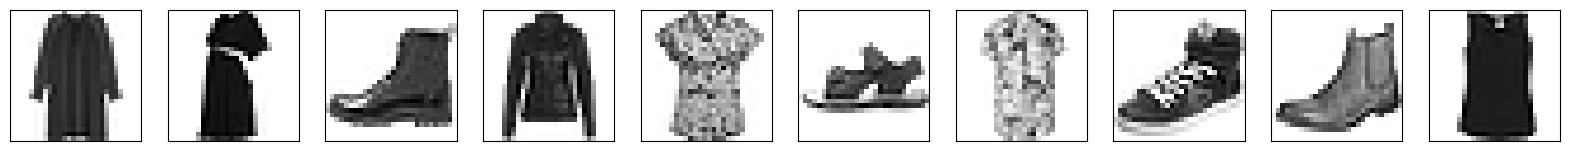

In [33]:
fig, axes = plt.subplots(ncols=10, sharey=True)
fig.set_size_inches(20, 5)
for axis in axes:
    axis.imshow(train_x[np.random.randint(low=0, high=len(train_x))].reshape(28, 28), cmap="binary")
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()